In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

from core.utils.device import DEVICE

model = AutoModelForCausalLM.from_pretrained("google/gemma-3-1b-pt")
model.to(DEVICE)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("google/gemma-3-1b-pt")

# EN-RU


Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/220 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/214 [00:00<?, ?it/s]

Data len:  50


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


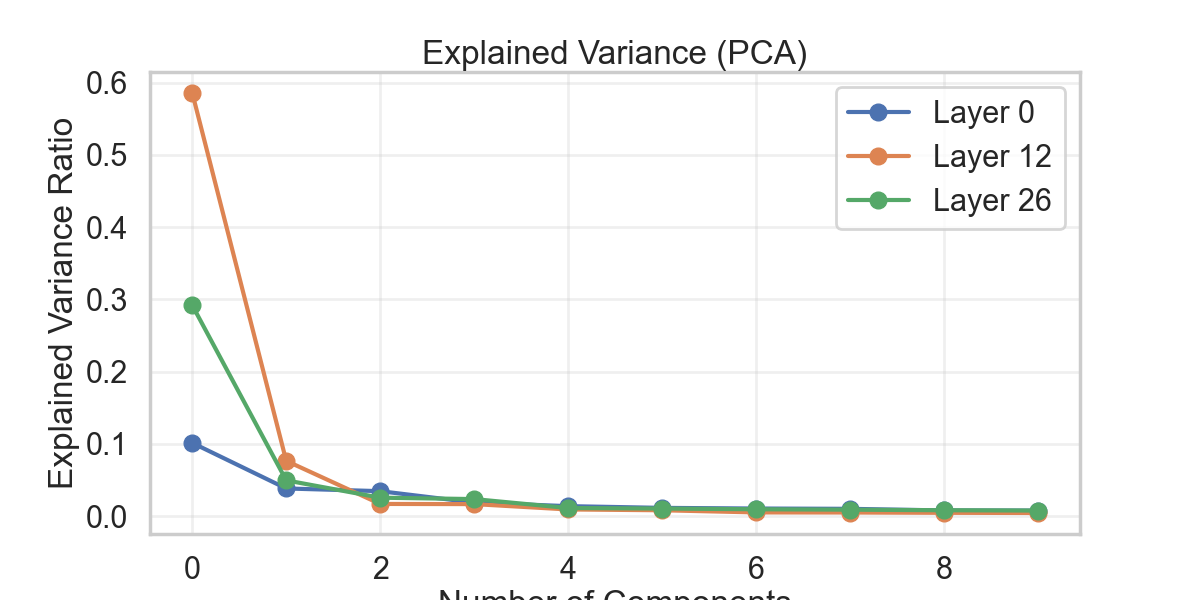

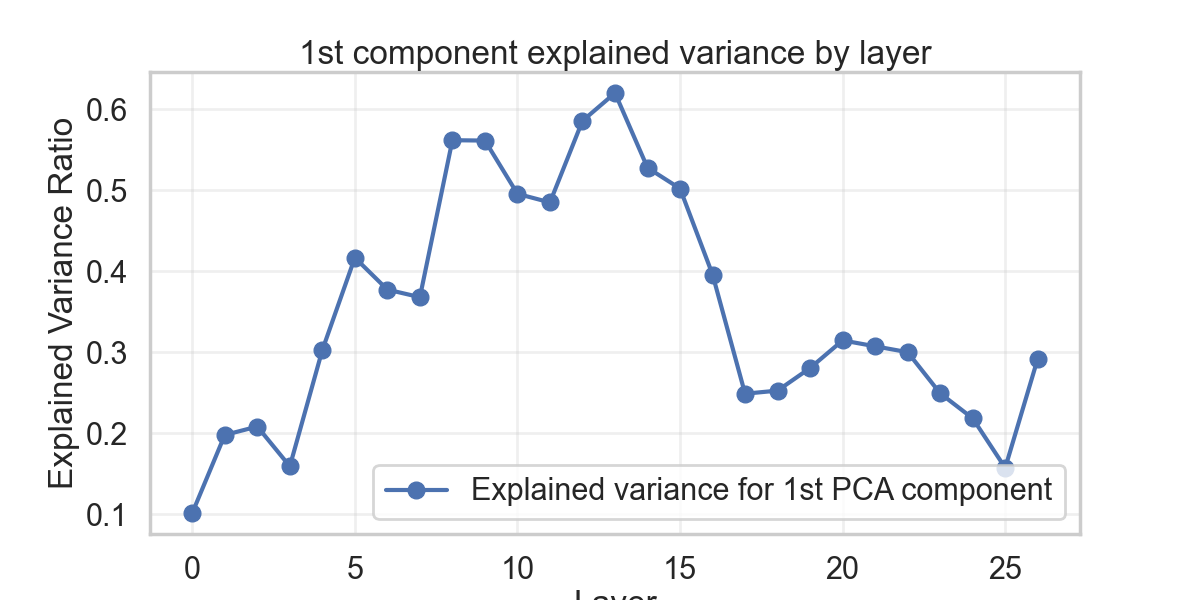

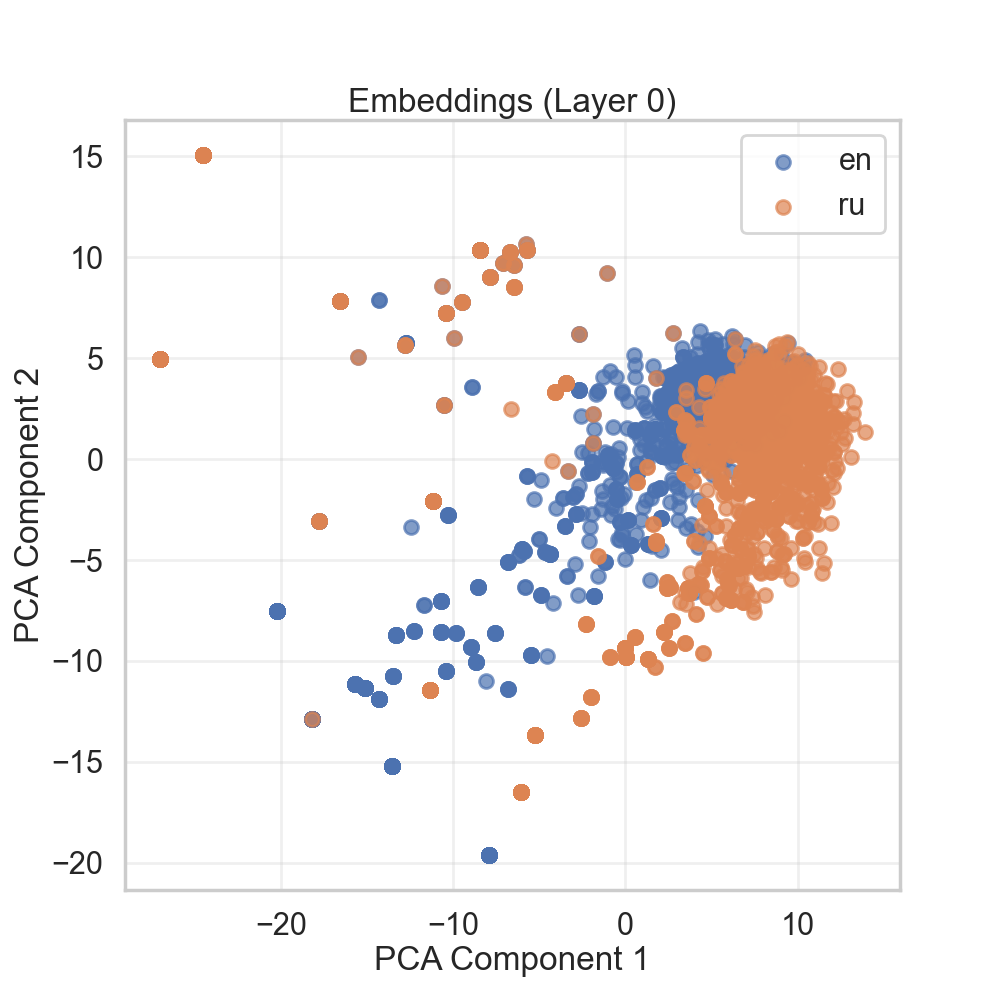

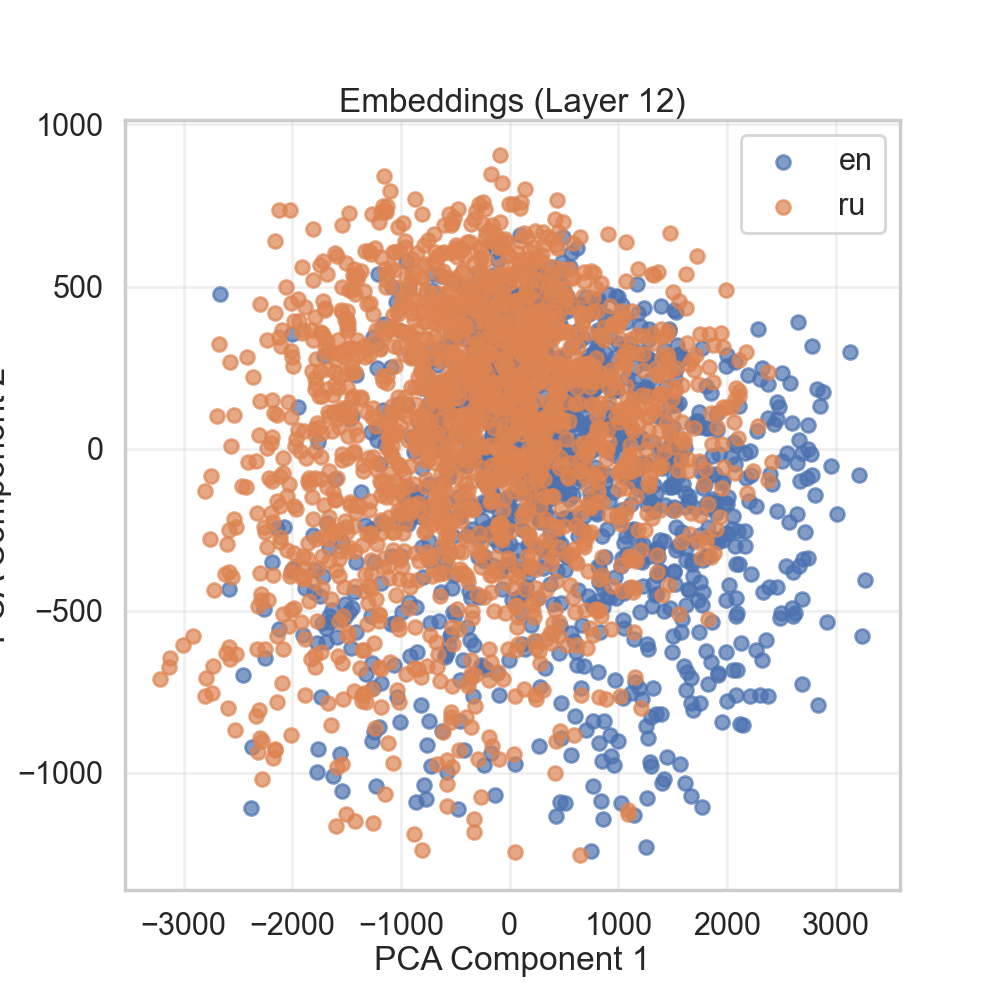

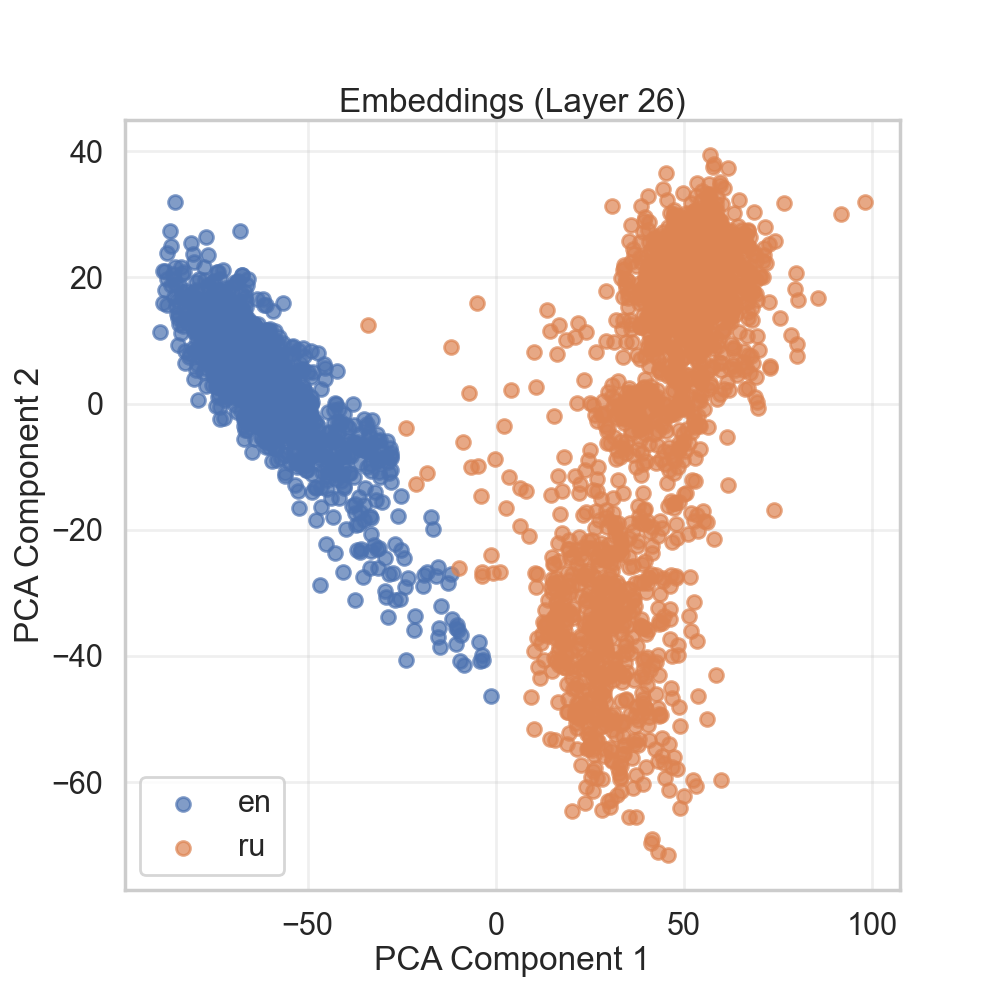

Data len:  100


100%|██████████| 100/100 [00:26<00:00,  3.71it/s]


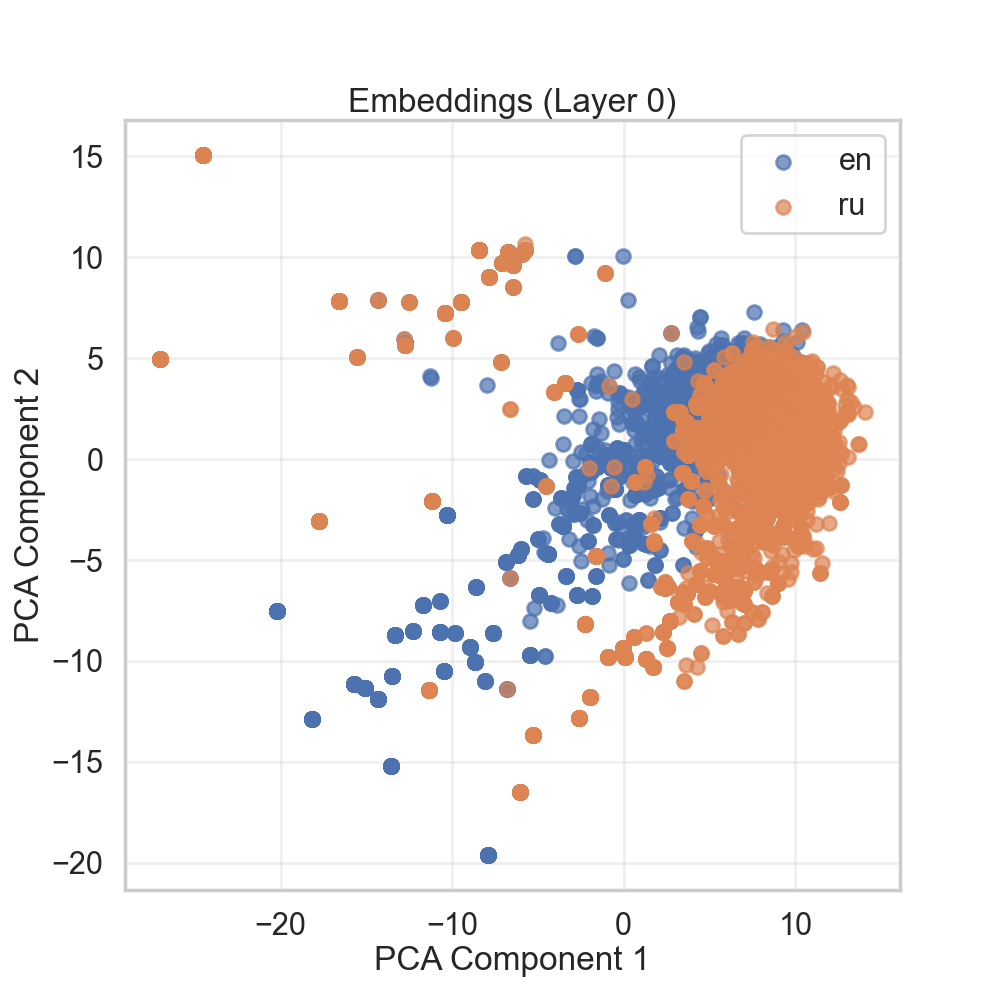

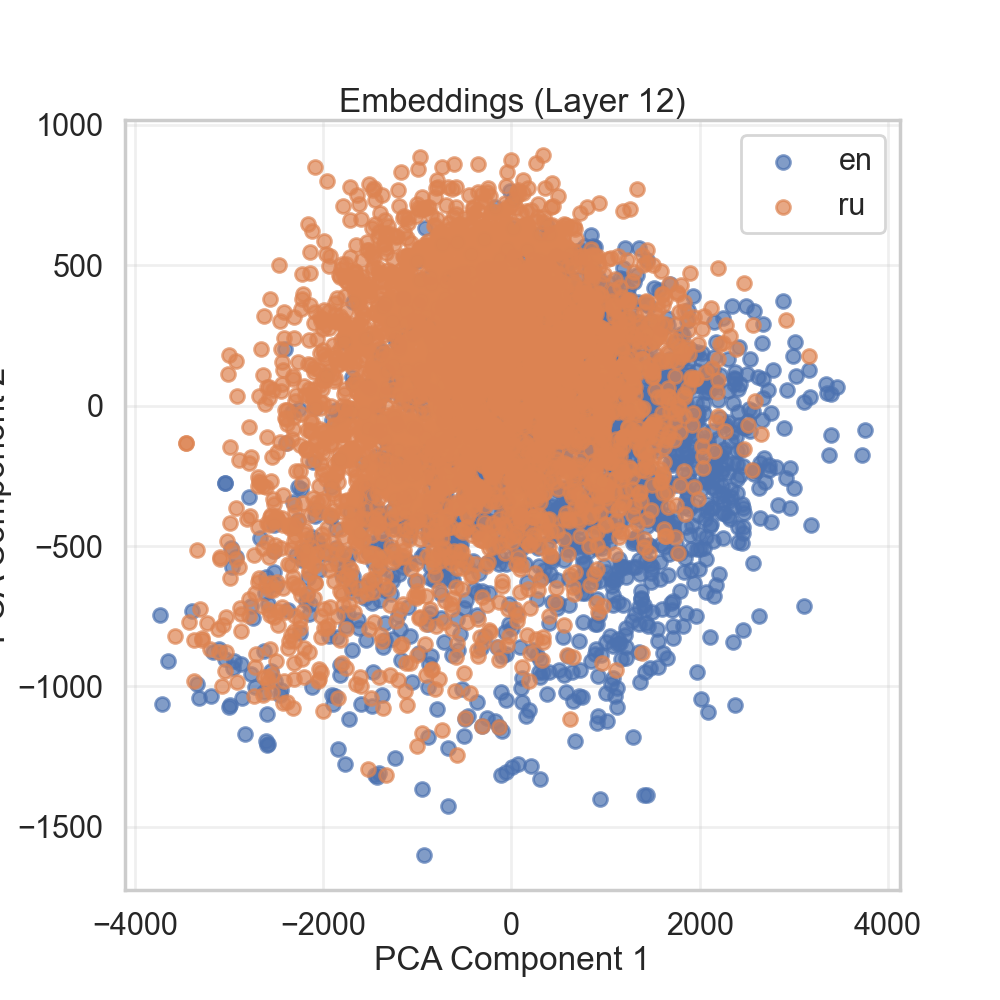

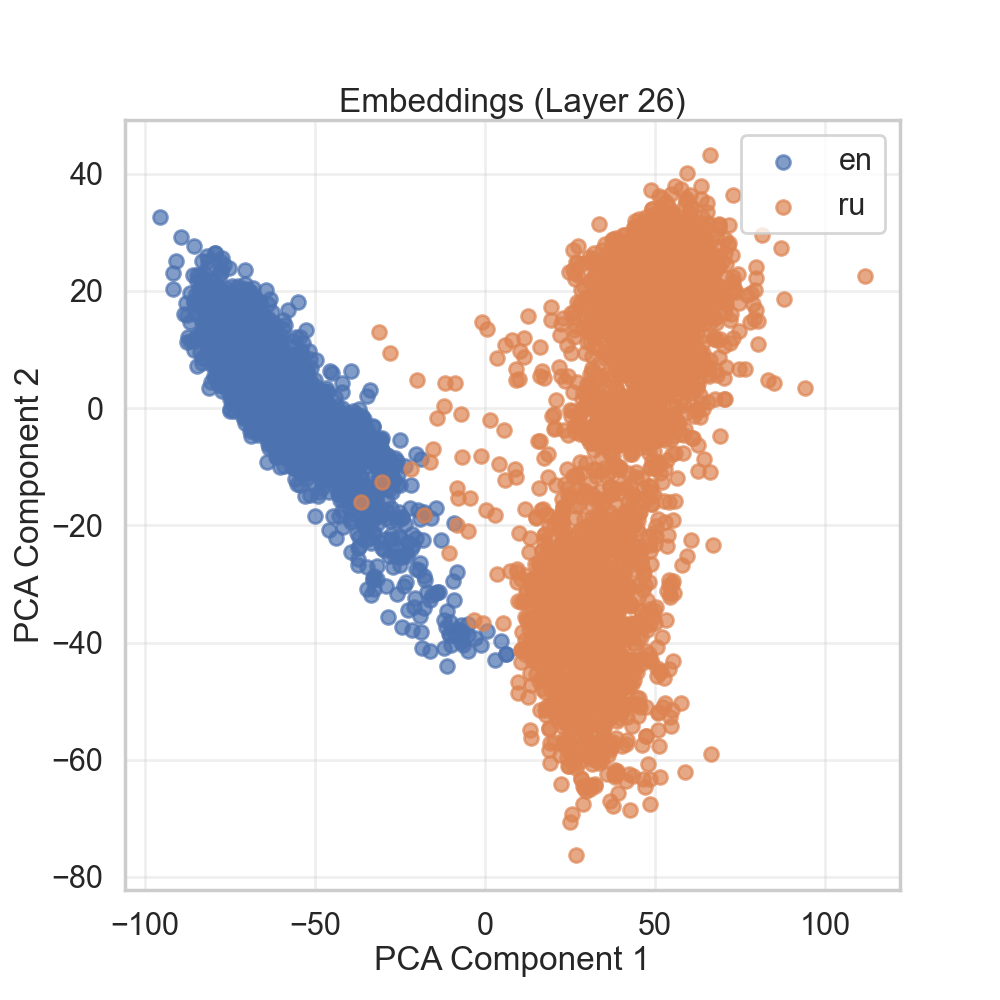

In [3]:
import numpy as np

from core.gather_data.hidden_space import collect_hidden_space_by_language
from core.pca.process_hidden_space import extract_pca_components, project_onto_pca
from core.pca.visualize import visualize_explained_variance, visualize_projections
from core.preprocess_data.flores_plus import load_flores_plus

train_df, test_df = load_flores_plus(["eng_Latn", "rus_Cyrl"], {"eng_Latn": "en", "rus_Cyrl": "ru"}, train_size=50)

test_df = test_df[:100]

hidden_space_by_language_train, token_map_by_language_train = collect_hidden_space_by_language(
    model, tokenizer, train_df
)
combined_embeddings = np.concat(list(hidden_space_by_language_train.values()), axis=1)
pca_components, pca_means, explained_variance_ratios = extract_pca_components(combined_embeddings)
visualize_explained_variance(explained_variance_ratios)

projections_train = project_onto_pca(hidden_space_by_language_train, pca_components, pca_means)
visualize_projections(hidden_space_by_language_train, token_map_by_language_train, projections_train, tokenizer)

hidden_space_by_language_test, token_map_by_language_test = collect_hidden_space_by_language(model, tokenizer, test_df)
projections_test = project_onto_pca(hidden_space_by_language_test, pca_components, pca_means)
visualize_projections(hidden_space_by_language_test, token_map_by_language_test, projections_test, tokenizer)

In [20]:
model

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear(in_features=6912, out_features=1152, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((11

In [21]:
original_forward = model.model.norm.forward

In [22]:
import torch
import torch.nn as nn

flip_l = 0.0  # reflection strength along PCA dir: 0=noop, 0.5=removal, 1.0=full reflection
flip_c = 0.0  # optional residual scaling (kept for compatibility; 0.0 = noop)


class CustomPassthroughLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # x: [..., d_model] (typically [B, T, D])
        # Build mean and direction on correct device/dtype
        mu = torch.as_tensor(pca_means[-1], device=x.device, dtype=x.dtype)  # [D]
        pc = torch.as_tensor(pca_components[-1][0], device=x.device, dtype=x.dtype)  # [D]
        pc = pc / (pc.norm() + 1e-12)  # unit direction

        # Center
        centered = x - mu

        # Projection onto pc
        coeff = (centered * pc).sum(dim=-1, keepdim=True)  # [..., 1]
        proj = coeff * pc  # [..., D]
        resid = centered - proj  # orthogonal component

        # Householder-style transform: centered' = centered - 2*t*(proj)
        # Equivalently: resid + (1 - 2*t)*proj
        t = float(flip_l) if "flip_l" in globals() else 0.0
        centered_ref = resid + (1.0 - 2.0 * t) * proj

        # Optional residual scaling (compat): scale shared part if flip_c != 0
        if "flip_c" in globals() and flip_c != 0.0:
            centered_ref = (1.0 + float(flip_c)) * resid + (1.0 - 2.0 * t) * proj

        # Re-add mean
        r = mu + centered_ref
        return r


# Insert the custom layer after model.model.norm
custom_layer = CustomPassthroughLayer()


def new_forward(x):
    x = original_forward(x)
    x = custom_layer(x)
    return x


model.model.norm.forward = new_forward

In [23]:
inputs = tokenizer(["Hello darkness "], return_tensors="pt", add_special_tokens=True)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

flip_l = 1.5
flip_c = 0

with torch.no_grad():
    generated = model.generate(
        **inputs,
        max_new_tokens=30,
        do_sample=False,  # or True with temperature/top_k for sampling
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )

print(tokenizer.decode(generated[0], skip_special_tokens=True))

Hello darkness 🌙 и welcome к моим post'ам!

Today я хочу рассказать about my любимые anime!

First я хочу рассказать про anime которые я


# EN-CN


# EN-ES


# EN-CN-ES-Arab
